<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/clustering_and_classification/EarlyClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Early Classification of Time Series (ECTS)**

"The aim of early classification is to analyse the sequence data at each time point continuously and predict the class label when a sufficient amount of data is available. Thus, the decision of early classification is a challenging task that needs to be addressed." [1]

Early Classification on Time Series is "an effective 1-nearest neighbor classification method which makes prediction early and at the same time retains an accuracy comparable to that of a 1NN classifier using the full-length time series." [3]

"The problem is expressed differently by different researchers, but it generally reduced to asking if we can classify a time series subsequence with sufficient accuracy and confidence after seeing only some prefix of a target pattern." [4]

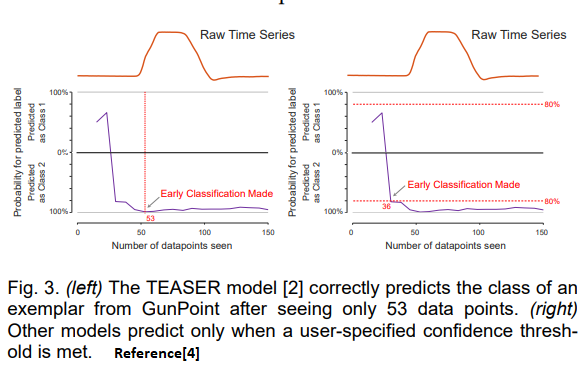


**Pros:**


*   Via ECTS, "classification without waiting for the entire pattern to appear would allow us to take immediate action in a domain in which some interventions are possible." [4]



**Cons:**


*   Can be "Disconnect to the Real World." [4].  It may not accurately represent the real world or may not be practical in some real world cases.
*   "ETSC is much harder than it appears." [4]
*   "Domains where ETSC could be meaningfully applied is vanishingly small" [4] due to:
  *   "**The prefix problem** is the assumption that the pattern to be early classified is not a prefix of a longer innocuous pattern." [4]
  *   "**The inclusion problem** is the assumption that the pattern to be early classified is not comprised of smaller atomic units that are frequently observed on their own." [4]
  *   "**The homophone problem** is the assumption that two semantically different events will have different shapes in the time series representation." [4]
*   Susceptible to "cheating" by "peeking into the future." [4]
*   "Difficult to find data sets that make sense for ECTS." [4]

**References:**

1.   https://ieeexplore.ieee.org/document/9066213
2.   https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_early_classification.html#sphx-glr-auto-examples-classification-plot-early-classification-py
3.   https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.205.2478&rep=rep1&type=pdf
4.   https://arxiv.org/ftp/arxiv/papers/2102/2102.11487.pdf




In [1]:
# Run this to clone the ai engine to colab
!git clone https://github.com/sjc230/ai_engine.git

Cloning into 'ai_engine'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 219 (delta 60), reused 194 (delta 35), pack-reused 0
Receiving objects: 100% (219/219), 11.81 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [2]:
# Run this only if you need to pull updated file from the github repository
# to pull, the colab directory must be changed to the ai engine directeroy
# after pulling, you must switch back to the original directory
%cd ai_engine
!git pull
%cd ..

/content/ai_engine
Already up to date.
/content


In [3]:
!pip install sktime
!pip install chart_studio
!python -m pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 980.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.1 MB/s eta 0:00:00


In [4]:
from math import radians
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pathlib import Path

#import streamlit as st

import re
import pytz
from datetime import datetime
from datetime import date

import enum
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, auc, roc_curve, roc_auc_score

from tslearn.early_classification import NonMyopicEarlyClassifier

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [5]:
# GET TIME SERIES DATASET
# steps 1, 2 - prepare osuleaf dataset (train and new)
from sktime.datasets import load_italy_power_demand

X_train, y_train = load_italy_power_demand(split="train", return_type="numpy2D")
X_test, y_test = load_italy_power_demand(split="test", return_type="numpy2D")

print("shape of X_train ",X_train.shape)
print("shape of y_train ",y_train.shape)
print("shape of X_test ",X_test.shape)
print("shape of y_test ",y_test.shape)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

n_classes = int(np.amax(y_train))
print("number of classes is ",n_classes)

shape of X_train  (67, 24)
shape of y_train  (67,)
shape of X_test  (1029, 24)
shape of y_test  (1029,)
number of classes is  2


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 67 1-dimensional timeseries
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1029 1-dimensional timeseries
  warnings.warn(


Best parameter (CV score=-0.240):
{'early__base_classifier': None, 'early__cost_time_parameter': 1.0, 'early__lamb': 1.0, 'early__min_t': 1, 'early__n_clusters': 2}


/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1029 1-dimensional timeseries
  warnings.warn(


              precision    recall  f1-score   support

           1       0.71      0.67      0.69       513
           2       0.69      0.73      0.71       516

    accuracy                           0.70      1029
   macro avg       0.70      0.70      0.70      1029
weighted avg       0.70      0.70      0.70      1029



/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1029 1-dimensional timeseries
  warnings.warn(


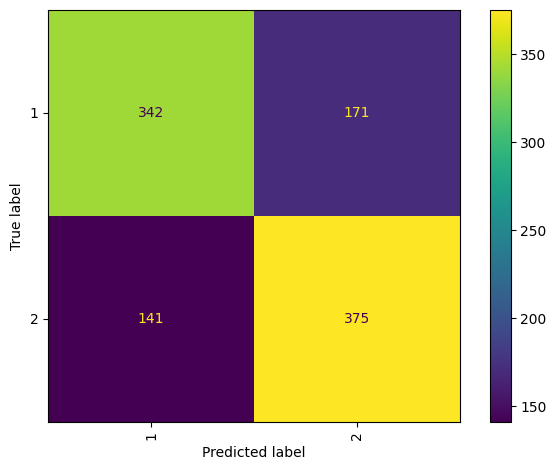

In [6]:
# SETUP & RUN ADABOOST GRIDSEARCH TRAINING & TESTING

# import the classifier builder from the cloned python files
import ai_engine.sk_classifier_builder as skc

early = skc.pipeBuild_NonMyopicEarlyClassifier(n_clusters=[n_classes])

names=['Non-Myopic Early']
pipes=[early]


samples = np.arange(len(X_train[0,:]))

# iterate over classifiers
for j in range(len(names)):

    today = date.today()
    now = today.strftime("%b-%d-%Y")
    save_file = str(names[j]) + '-' + str(now) + '-HeatMap.png'

    grid_search = GridSearchCV(estimator=pipes[j][0], param_grid=pipes[j][1], scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    score = grid_search.score(X_test, y_test)
    print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
    print(grid_search.best_params_)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, xticks_rotation="vertical")

plt.tight_layout()
plt.show()